<a href="https://www.kaggle.com/code/shinnosukeino/dogecoin-price-prediction-model?scriptVersionId=106479800" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dogecoin Price Prediction

**This is a machine learning model to predict Dogecoin's price!**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
/kaggle/input/cryptocurrencypricehistory/coin_ChainLink.csv
/kaggle/input/cryptocurrencypricehistory/coin_Cardano.csv
/kaggle/input/cryptocurrencypricehistory/coin_Solana.csv
/kaggle/input/cryptocurrencypricehistory/coin_Dogecoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_Polkadot.csv
/kaggle/input/cryptocurrencypricehistory/coin_NEM.csv
/kaggle/input/cryptocurrencypricehistory/coin_XRP.csv
/kaggle/input/cryptocurrencypricehistory/coin_Ethereum.csv
/kaggle/input/cryptocurrencypricehistory/coin_Aave.csv
/kaggle/input/cryptocurrencypricehistory/coin_Bitcoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_Cosmos.csv
/kaggle/input/cryptocurrencypricehistory/coin_Litecoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_Uniswap.csv
/kaggle/input/cryptocurrencypricehistory/coin_EOS.csv
/kaggle/input/cryptocurrencypricehistory/coin_BinanceCoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_C

After we have downloaded the data, we can first look at the data, and then drop the unnecessary columns.
Next, we will make the date column as an index.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tensorflow as tf

df = pd.read_csv('../input/cryptocurrencypricehistory/coin_Dogecoin.csv')
df.drop(columns = ['SNo','Name','Symbol','Open','Close', 'Volume', 'Marketcap', "Low"], axis=1,errors='ignore', inplace = True)
# df['Date'] = df["Date"].dt.strftime('%y-%m-%d')
df['Date'] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].astype('datetime64[ns]')

df.set_index("Date", inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2760 entries, 2013-12-16 to 2021-07-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    2760 non-null   float64
dtypes: float64(1)
memory usage: 43.1 KB


Convert the dataframe into numpy arrays.

In [3]:
timesteps = df.index.to_numpy()
prices = df["High"].to_numpy()
timesteps = tf.convert_to_tensor(df.index.values.astype(np.int64))

timesteps[:10], prices[:10]

2022-09-25 09:45:28.598098: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(<tf.Tensor: shape=(10,), dtype=int64, numpy=
 array([1387152000000000000, 1387238400000000000, 1387324800000000000,
        1387411200000000000, 1387497600000000000, 1387584000000000000,
        1387670400000000000, 1387756800000000000, 1387843200000000000,
        1387929600000000000])>,
 array([0.00086587, 0.00028879, 0.00036163, 0.00151967, 0.00114292,
        0.00070049, 0.00049758, 0.00045953, 0.00091305, 0.00069368]))

Split the data into 80% training data, and 20% test data.

In [4]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2208, 552, 2208, 552)

Now, let's plot the Dogecoin price.

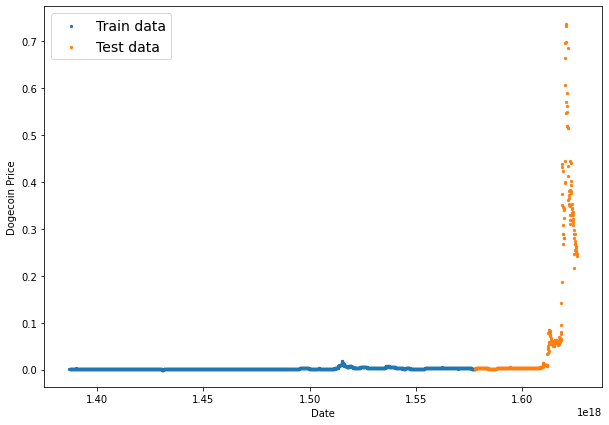

In [5]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Dogecoin Price")
plt.legend(fontsize=14)
plt.show();

Let's create a function so that we can plot the data easily.

In [6]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Dogecoin Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

First of all, we could get on with the naive forecasting!

In [7]:
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([0.00211001, 0.00217721, 0.00248978, 0.0024913 , 0.00256355,
        0.0024968 , 0.00246518, 0.00231418, 0.00236058, 0.0023729 ]),
 array([0.25512667, 0.26689135, 0.26698212, 0.27493964, 0.2635378 ,
        0.26009185, 0.24799679, 0.25021383, 0.25256665, 0.24641907]))

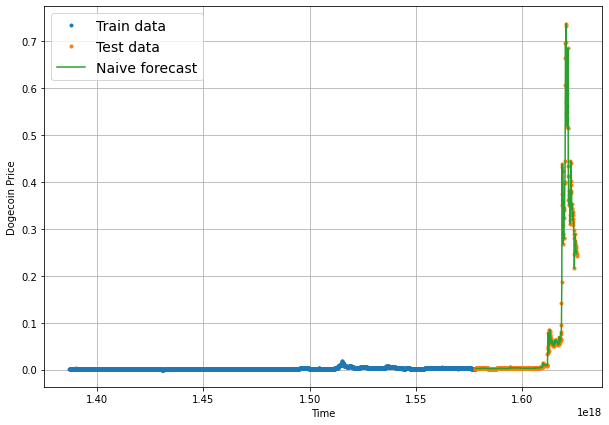

In [8]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

In [9]:
y_true = tf.cast(y_test[1:], dtype=tf.float32)
y_pred = tf.cast(naive_forecast, dtype=tf.float32)

  # Calculate various metrics
mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
print(mae)

tf.Tensor(0.0059012035, shape=(), dtype=float32)


Let's plot the data using plot_time_series function.

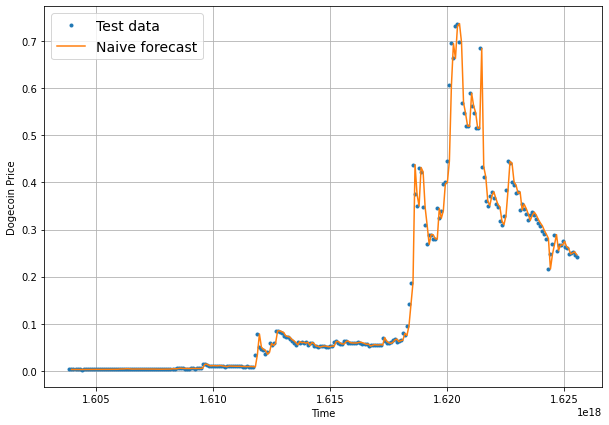

In [10]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

Let's make a windows and horizons.

Input of WINDOW_SIZE = 7 and output of HORIZON = 1.

In [11]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Make a function that you can pass in an array and then split the array into 2 arrays. First array will contain numbers that are from the start till the total number minus the amount of horizon.

In [12]:
def get_labelled_windows(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]

Let's make a function that you can actually make the windows.

In [13]:
def make_windows(x, window_size=7, horizon=1):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis = 0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

Let's check that the make_windows function works and create windows and labels for the whole data.

In [14]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# train_windows, train_labels, test_windows, test_labels
full_windows, full_labels

(array([[0.00086587, 0.00028879, 0.00036163, ..., 0.00114292, 0.00070049,
         0.00049758],
        [0.00028879, 0.00036163, 0.00151967, ..., 0.00070049, 0.00049758,
         0.00045953],
        [0.00036163, 0.00151967, 0.00114292, ..., 0.00049758, 0.00045953,
         0.00091305],
        ...,
        [0.26689135, 0.26698212, 0.27493964, ..., 0.26009185, 0.24799679,
         0.25021383],
        [0.26698212, 0.27493964, 0.2635378 , ..., 0.24799679, 0.25021383,
         0.25256665],
        [0.27493964, 0.2635378 , 0.26009185, ..., 0.25021383, 0.25256665,
         0.24641907]]),
 array([[0.00045953],
        [0.00091305],
        [0.00069368],
        ...,
        [0.25256665],
        [0.24641907],
        [0.24190981]]))

Checking that the datas are stored correctly.

In [15]:
for i in range(3):
    print(f'{full_windows[i]}, {full_labels[i]}')

[0.00086587 0.00028879 0.00036163 0.00151967 0.00114292 0.00070049
 0.00049758], [0.00045953]
[0.00028879 0.00036163 0.00151967 0.00114292 0.00070049 0.00049758
 0.00045953], [0.00091305]
[0.00036163 0.00151967 0.00114292 0.00070049 0.00049758 0.00045953
 0.00091305], [0.00069368]


Making a function that you can split the windows and the labels 80% training data and 20% test data.

In [16]:
def split_train_test(windows, labels):
    split_windows = int(0.8 * len(windows))
    split_labels = int(0.8 * len(labels))  # 80% train, 20% test
    # Create train data splits (everything before the split)
    x_train, x_test = windows[:split_windows], windows[split_windows:]

    # Create test data splits (everything after the split)
    y_train, y_test = labels[:split_labels], labels[split_labels:]

    return x_train, x_test, y_train, y_test

Let's just check that the datas are splited correctly by looking at the length of the data.

In [17]:
train_windows, test_windows, train_labels, test_labels = split_train_test(full_windows, full_labels)
# train_windows, test_windows, train_labels, test_labels
# len(full_windows), len(full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2202, 551, 2202, 551)

Checking the actual data.

In [18]:
train_windows[:5], test_windows[:5], train_labels[:5], test_labels[:5]

(array([[0.00086587, 0.00028879, 0.00036163, 0.00151967, 0.00114292,
         0.00070049, 0.00049758],
        [0.00028879, 0.00036163, 0.00151967, 0.00114292, 0.00070049,
         0.00049758, 0.00045953],
        [0.00036163, 0.00151967, 0.00114292, 0.00070049, 0.00049758,
         0.00045953, 0.00091305],
        [0.00151967, 0.00114292, 0.00070049, 0.00049758, 0.00045953,
         0.00091305, 0.00069368],
        [0.00114292, 0.00070049, 0.00049758, 0.00045953, 0.00091305,
         0.00069368, 0.00070573]]),
 array([[0.0020751 , 0.00209028, 0.00211417, 0.00207719, 0.00205636,
         0.0020521 , 0.00211001],
        [0.00209028, 0.00211417, 0.00207719, 0.00205636, 0.0020521 ,
         0.00211001, 0.00217721],
        [0.00211417, 0.00207719, 0.00205636, 0.0020521 , 0.00211001,
         0.00217721, 0.00248978],
        [0.00207719, 0.00205636, 0.0020521 , 0.00211001, 0.00217721,
         0.00248978, 0.0024913 ],
        [0.00205636, 0.0020521 , 0.00211001, 0.00217721, 0.00248978,
  

Now let's make the actual machine learning model.

The output is going to be HORIZON which will be 1 in our case.

In [19]:
import tensorflow as tf
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON, activation='linear')
])

model_1.compile(loss='mae',
             optimizer='adam')

model_1.fit(x=train_windows, y=train_labels, batch_size=128, epochs=100, verbose=1, validation_data=(test_windows, test_labels))
model_1.summary()

2022-09-25 09:45:32.242479: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
18/18 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0306
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 4.0787e-04 - val_loss: 0.0243
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 3.6246e-04 - val_loss: 0.0237
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 2.2377e-04 - val_loss: 0.0248
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 2.0467e-04 - val_loss: 0.0279
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 2.2287e-04 - val_loss: 0.0286
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 2.3178e-04 - val_loss: 0.0262
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 2.3169e-04 - val_loss: 0.0265
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 2.9516e-04 - val_loss: 0.0267
Epoch 10/100
18/18 [==============================] - 0s 4ms/step - loss: 2.

Okay, so loss of 0.0330 is not too bad, but I think we can do better.

In [20]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 0.0330


0.03299931064248085

Next, I'm going to try the neural network even deeper.
I'm also going to make the batch_size bigger.

In [21]:
import tensorflow as tf
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(HORIZON, activation='linear')
])

model_2.compile(loss='mae',
             optimizer='adam')

model_2.fit(x=train_windows, y=train_labels, batch_size=200, epochs=100, verbose=1, validation_data=(test_windows, test_labels))
model_2.summary()

Epoch 1/100
12/12 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0516
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0430
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 8.4086e-04 - val_loss: 0.0329
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 5.6297e-04 - val_loss: 0.0187
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 8.2514e-04 - val_loss: 0.0154
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 5.4871e-04 - val_loss: 0.0131
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 4.5670e-04 - val_loss: 0.0139
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 3.4337e-04 - val_loss: 0.0130
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 5.2575e-04 - val_loss: 0.0136
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 2.6291

0.0155!! NICE!

In [22]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 0.0155


0.015451429411768913

Now let's make a forecasting function.

In [23]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [24]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(551,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.00227076, 0.00230304, 0.00242489, 0.00252193, 0.00259975,
        0.00264236, 0.00264691, 0.0026033 , 0.00257795, 0.00256769],
       dtype=float32)>)

Let's plot the actual data and the predictions that our models have made.

As you can see, the model_1's prediction was quite different from the actual data.

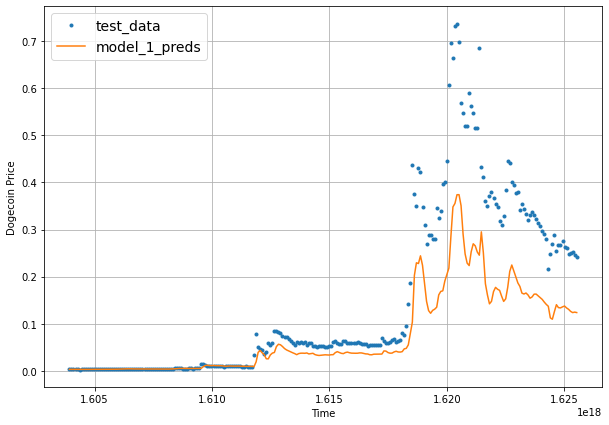

In [25]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds") 

In [26]:
model_2_preds = make_preds(model_2, test_windows)
len(model_2_preds), model_2_preds[:10]

(551,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.00223985, 0.00226289, 0.00234998, 0.00242672, 0.00250468,
        0.002565  , 0.00259024, 0.00258746, 0.00258442, 0.00256961],
       dtype=float32)>)

However, model_2 is doing much better with the forecast!

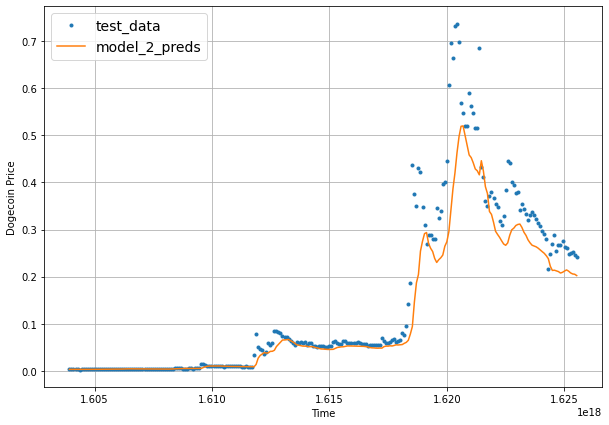

In [27]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

Next, I'm going to make model_3 using LSTM layers.
But before we do that, we have to expand the dimesion of input to use LSTM.

In [28]:
x = tf.constant(train_windows[0])
expand_dims_layers = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(x.shape)
print(f'{expand_dims_layers(x).shape}')

(7,)
(7, 1)


Okay, let's get on with the model.

In [29]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
   tf. keras.layers.Dense(HORIZON, activation='linear'),
])
model_3.compile(loss='mae',
             optimizer='adam')
model_3.fit(x=train_windows, y=train_labels, batch_size=128, epochs = 100, verbose=1, validation_data=(test_windows, test_labels))
model_3.summary()


Epoch 1/100
18/18 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 0.0501
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0449
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 8.9463e-04 - val_loss: 0.0288
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 8.6723e-04 - val_loss: 0.0160
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 6.6081e-04 - val_loss: 0.0115
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 9.6232e-04 - val_loss: 0.0123
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 6.0884e-04 - val_loss: 0.0127
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0134
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 3.2730e-04 - val_loss: 0.0112
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 6.4114e-04

Well done guys! We have beaten model_2!

In [30]:
model_3_preds = make_preds(model_3, test_windows)
len(model_3_preds), model_3_preds[:10]

(551,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.00197062, 0.0019935 , 0.00208223, 0.00215691, 0.0022302 ,
        0.00227872, 0.00230558, 0.00229197, 0.00228811, 0.00227376],
       dtype=float32)>)

And the plot looks better than the plot of model_2.

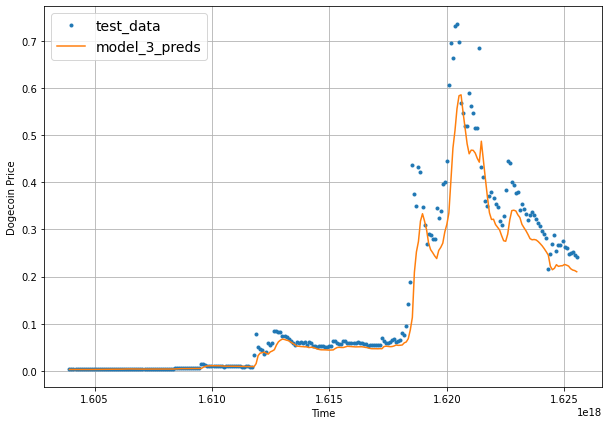

In [31]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, format="-", label="model_3_preds") 

Next, let's try try the Bidirectional LSTM layers.

In [32]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dense(128, activation='relu'),
   tf. keras.layers.Dense(HORIZON, activation='linear'),
])
model_4.compile(loss='mae',
             optimizer='adam')
model_4.fit(x=train_windows, y=train_labels, batch_size=128, epochs = 100, verbose=1, validation_data=(test_windows, test_labels))
model_4.summary()


Epoch 1/100
18/18 [==============================] - 19s 247ms/step - loss: 0.0025 - val_loss: 0.0687
Epoch 2/100
18/18 [==============================] - 1s 80ms/step - loss: 0.0015 - val_loss: 0.0673
Epoch 3/100
18/18 [==============================] - 1s 78ms/step - loss: 0.0014 - val_loss: 0.0645
Epoch 4/100
18/18 [==============================] - 1s 79ms/step - loss: 0.0015 - val_loss: 0.0639
Epoch 5/100
18/18 [==============================] - 1s 79ms/step - loss: 0.0013 - val_loss: 0.0572
Epoch 6/100
18/18 [==============================] - 1s 78ms/step - loss: 0.0015 - val_loss: 0.0557
Epoch 7/100
18/18 [==============================] - 1s 78ms/step - loss: 8.0018e-04 - val_loss: 0.0411
Epoch 8/100
18/18 [==============================] - 2s 96ms/step - loss: 0.0016 - val_loss: 0.0613
Epoch 9/100
18/18 [==============================] - 2s 98ms/step - loss: 0.0014 - val_loss: 0.0597
Epoch 10/100
18/18 [==============================] - 1s 78ms/step - loss: 7.3388e-04 - val_lo

Model_4 doesn't look too good.
Maybe we overfit the model.

In [33]:
model_4_preds = make_preds(model_4, test_windows)
len(model_4_preds), model_4_preds[:10]

(551,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.00227119, 0.00229387, 0.00238388, 0.00245719, 0.00253666,
        0.00258823, 0.00262462, 0.00261673, 0.00261815, 0.00260135],
       dtype=float32)>)

😭😭😭😭😭

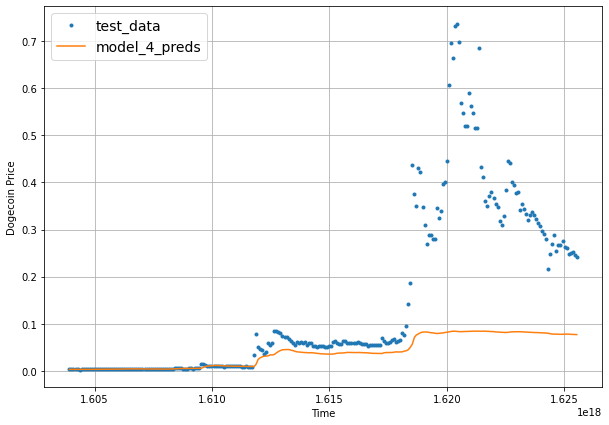

In [34]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_4_preds, start=offset, format="-", label="model_4_preds") 

I think the Bidirectional LSTM layers would work if we make the neural network shallower.
Let's get on with a shallower model.

In [35]:
tf.random.set_seed(42)

model_5 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dense(128, activation='relu'),
   tf. keras.layers.Dense(HORIZON, activation='linear'),
])
model_5.compile(loss='mae',
             optimizer='adam')
model_5.fit(x=train_windows, y=train_labels, batch_size=128, epochs = 100, verbose=1, validation_data=(test_windows, test_labels))
model_5.summary()


Epoch 1/100
18/18 [==============================] - 6s 67ms/step - loss: 0.0018 - val_loss: 0.0486
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 8.9080e-04 - val_loss: 0.0313
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 9.7272e-04 - val_loss: 0.0206
Epoch 4/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0223
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 5.5166e-04 - val_loss: 0.0175
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 7.4119e-04 - val_loss: 0.0175
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 8.8278e-04 - val_loss: 0.0190
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 8.5553e-04 - val_loss: 0.0210
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 3.3358e-04 - val_loss: 0.0146
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - los

Hmmm, not bad but not good enough.

In [36]:
model_5_preds = make_preds(model_5, test_windows)
len(model_5_preds), model_5_preds[:10]

(551,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.00171827, 0.00174413, 0.00184627, 0.00192556, 0.00201059,
        0.0020575 , 0.00209071, 0.00207312, 0.00207308, 0.00205542],
       dtype=float32)>)

Model_3 was better.

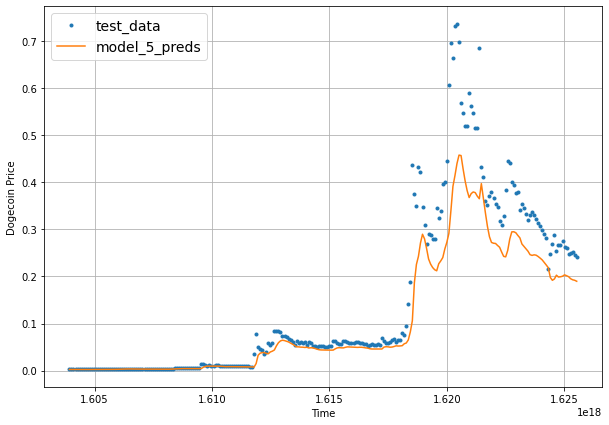

In [37]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_5_preds, start=offset, format="-", label="model_5_preds") 

So, we found out that model_3 was the best! Let's see if we can make it even better.
I decided to change the batch_size to 50.

In [38]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf. keras.layers.Dense(HORIZON, activation='linear'),
])
model_6.compile(loss='mae',
             optimizer='adam')
history_model_6 = model_6.fit(x=train_windows, y=train_labels, batch_size=50, epochs = 100, verbose=1, validation_data=(test_windows, test_labels))
model_6.summary()

Epoch 1/100
45/45 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0260
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 7.1905e-04 - val_loss: 0.0142
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 6.4631e-04 - val_loss: 0.0128
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 3.9327e-04 - val_loss: 0.0127
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 4.9653e-04 - val_loss: 0.0123
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 7.7143e-04 - val_loss: 0.0117
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 5.1820e-04 - val_loss: 0.0110
Epoch 8/100
45/45 [==============================] - 0s 4ms/step - loss: 5.5414e-04 - val_loss: 0.0115
Epoch 9/100
45/45 [==============================] - 0s 4ms/step - loss: 5.7168e-04 - val_loss: 0.0110
Epoch 10/100
45/45 [==============================] - 0s 4ms/step - loss: 6.3

Well done! We beat model_3!

In [39]:
model_6_preds = make_preds(model_6, test_windows)
len(model_6_preds), model_6_preds[:10]

(551,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.00206754, 0.00209924, 0.00222169, 0.00231309, 0.00239273,
        0.00242915, 0.00243795, 0.00239289, 0.00237179, 0.00235984],
       dtype=float32)>)

Looking good!

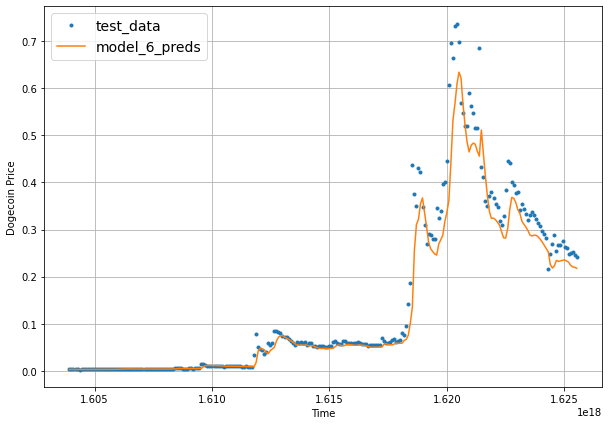

In [40]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_6_preds, start=offset, format="-", label="model_6_preds") 

But as you can see in the graph down below, the val_loss has gone up from approximately 90 epochs. Let's make model_7 with 90 epochs.

<AxesSubplot:>

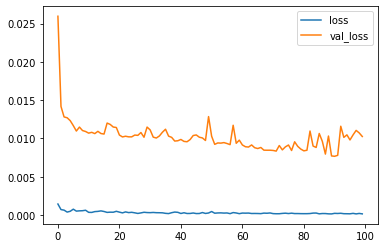

In [41]:
pd.DataFrame(history_model_6.history).plot()


In [42]:
tf.random.set_seed(42)

model_7 = tf.keras.Sequential([
    
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf. keras.layers.Dense(HORIZON, activation='linear'),
])
model_7.compile(loss='mae',
             optimizer='adam')
history_model_7 = model_7.fit(x=train_windows, y=train_labels, batch_size=50, epochs = 90, verbose=1, validation_data=(test_windows, test_labels))
model_7.summary()

Epoch 1/90
45/45 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0260
Epoch 2/90
45/45 [==============================] - 0s 4ms/step - loss: 7.1905e-04 - val_loss: 0.0142
Epoch 3/90
45/45 [==============================] - 0s 4ms/step - loss: 6.4631e-04 - val_loss: 0.0128
Epoch 4/90
45/45 [==============================] - 0s 3ms/step - loss: 3.9327e-04 - val_loss: 0.0127
Epoch 5/90
45/45 [==============================] - 0s 3ms/step - loss: 4.9653e-04 - val_loss: 0.0123
Epoch 6/90
45/45 [==============================] - 0s 4ms/step - loss: 7.7143e-04 - val_loss: 0.0117
Epoch 7/90
45/45 [==============================] - 0s 4ms/step - loss: 5.1820e-04 - val_loss: 0.0110
Epoch 8/90
45/45 [==============================] - 0s 4ms/step - loss: 5.5414e-04 - val_loss: 0.0115
Epoch 9/90
45/45 [==============================] - 0s 5ms/step - loss: 5.7168e-04 - val_loss: 0.0110
Epoch 10/90
45/45 [==============================] - 0s 3ms/step - loss: 6.3319e-04 - 

Looks good.

<AxesSubplot:>

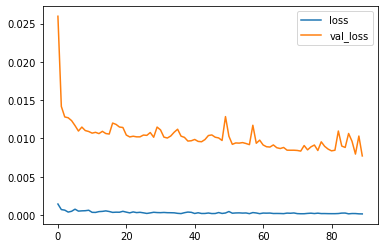

In [43]:
pd.DataFrame(history_model_7.history).plot()


In [44]:
model_7_preds = make_preds(model_7, test_windows)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00213922, 0.00216912, 0.0022848 , 0.00237309, 0.0024512 ,
       0.00248971, 0.00250173, 0.00246202, 0.00244386, 0.00243144],
      dtype=float32)>

Would you look at that! Looks extremely accurate.

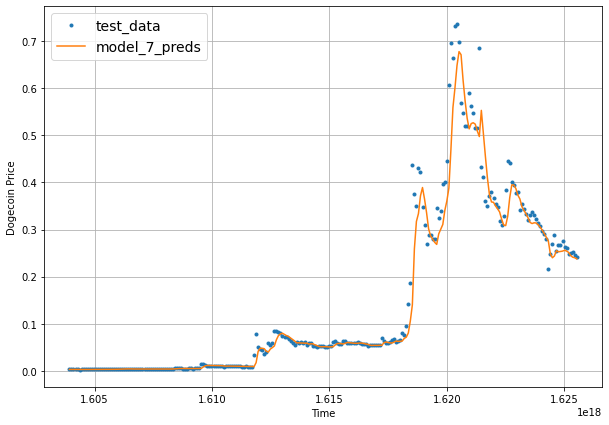

In [45]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_7_preds, start=offset, format="-", label="model_7_preds") 